In [63]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm
from utils import display

In [83]:
# Paramters
IMAGE_SIZE = 32
CHANNELS = 1 #Grayscale
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 10
BETA = 500

In [65]:
# Load data
(X_train, y_train), (X_test, y_test) = datasets.fashion_mnist.load_data()

In [66]:
# Preprocess data
def preprocess(imgs):
    imgs= imgs.astype("float32")/255.0
    imgs= np.pad(imgs, ((0,0), (2,2), (2,2)), constant_values=0.0)
    imgs= np.expand_dims(imgs, -1)
    return imgs

X_train= preprocess(X_train)
X_test= preprocess(X_test)

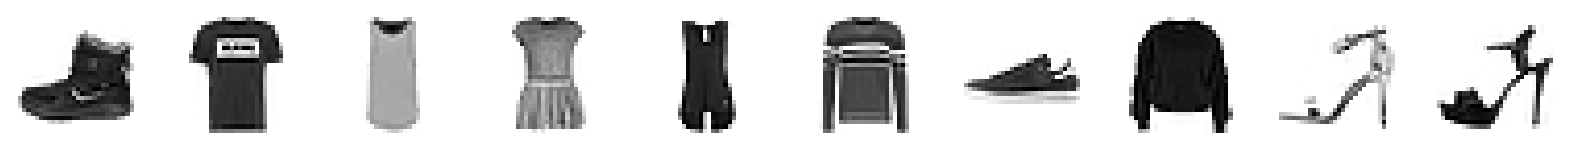

In [67]:
display(X_train)

In [68]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var= inputs
        batch= tf.shape(z_mean)[0]
        dim= tf.shape(z_mean)[1]
        epsilon= K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5*z_log_var)*epsilon

In [69]:
# Encoder
encoder_input= layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name= "encoder_input"
)
x= layers.Conv2D(32, (3,3), strides= 2, activation= "relu", padding= "same")( encoder_input)
x= layers.Conv2D(64, (3,3), strides= 2, activation= "relu", padding="same") (x)
x= layers.Conv2D(128, (3,3), strides= 2, activation= "relu", padding="same")(x)
before_flattening= K.int_shape(x)[1:]
x = layers.Flatten()(x)
# instead of 1 ouput it gives 2 
z_mean= layers.Dense(EMBEDDING_DIM, name= "z_mean")(x)
z_log_var= layers.Dense(EMBEDDING_DIM, name= "z_log_var")(x)

z= Sampling()([z_mean, z_log_var])
encoder= models.Model(encoder_input, [z_mean, z_log_var, z], name= "encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 16, 16, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_10 (Conv2D)             (None, 8, 8, 64)     18496       ['conv2d_9[0][0]']               
                                                                                                  
 conv2d_11 (Conv2D)             (None, 4, 4, 128)    73856       ['conv2d_10[0][0]']              
                                                                                            

In [70]:
len(encoder.outputs)

3

In [71]:
# Decoder
decoder_input= layers.Input(shape=(EMBEDDING_DIM,), name= "decoder_input")
x= layers.Dense(np.prod(before_flattening))(decoder_input)
x= layers.Reshape(before_flattening)(x)
x= layers.Conv2DTranspose(128, (3,3), strides= 2, activation= "relu", padding="same")(x)
x= layers.Conv2DTranspose(64, (3,3), strides= 2, activation="relu", padding= "same")(x)
x= layers.Conv2DTranspose(32, (3,3), strides= 2, activation="relu", padding= "same")(x)
decoder_output=layers.Conv2D(
    CHANNELS,
    (3,3),
    strides=1,
    activation= "sigmoid",
    padding= "same",
    name= "decoder_output",
)(x)
decoder= models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 2048)              6144      
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 8, 8, 128)        147584    
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 32, 32, 32)       1846

In [72]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.KL_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.KL_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            KL_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + KL_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.KL_loss_tracker.update_state(KL_loss)

        return {m.name: m.result() for m in self.metrics}

In [73]:
vae = VAE(encoder, decoder)

In [74]:
# Compile
optim= optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optim)

In [75]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [84]:
vae.fit(
    X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(X_test, X_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/10
600/600 [==============================] - ETA: 0s - total_loss: 132.3279 - reconstruction_loss: 127.2281 - kl_loss: 5.0999WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 89s 147ms/step - total_loss: 132.3279 - reconstruction_loss: 127.2281 - kl_loss: 5.0999 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 2/10
600/600 [==============================] - ETA: 0s - total_loss: 131.9143 - reconstruction_loss: 126.7923 - kl_loss: 5.1220WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 89s 148ms/step - total_loss: 131.9143 - reconstruction_loss: 126.7923 - kl_loss: 5.1220 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 3/10
600/600 [==============================] - ETA: 0s - total_loss: 131.6083 - reconstruction_loss: 126.4527 - kl_loss: 5.1557WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 88s 147ms/step - total_loss: 131.6083 - reconstruction_loss: 126.4527 - kl_loss: 5.1557 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 4/10
600/600 [==============================] - ETA: 0s - total_loss: 131.3626 - reconstruction_loss: 126.1793 - kl_loss: 5.1833WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 94s 156ms/step - total_loss: 131.3626 - reconstruction_loss: 126.1793 - kl_loss: 5.1833 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 5/10
600/600 [==============================] - ETA: 0s - total_loss: 131.1060 - reconstruction_loss: 125.9023 - kl_loss: 5.2037WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 91s 151ms/step - total_loss: 131.1060 - reconstruction_loss: 125.9023 - kl_loss: 5.2037 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 6/10
600/600 [==============================] - ETA: 0s - total_loss: 130.8972 - reconstruction_loss: 125.6809 - kl_loss: 5.2163WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 89s 148ms/step - total_loss: 130.8972 - reconstruction_loss: 125.6809 - kl_loss: 5.2163 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 7/10
600/600 [==============================] - ETA: 0s - total_loss: 130.7041 - reconstruction_loss: 125.4580 - kl_loss: 5.2462WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 88s 147ms/step - total_loss: 130.7041 - reconstruction_loss: 125.4580 - kl_loss: 5.2462 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 8/10
600/600 [==============================] - ETA: 0s - total_loss: 130.5677 - reconstruction_loss: 125.2942 - kl_loss: 5.2736WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 87s 145ms/step - total_loss: 130.5677 - reconstruction_loss: 125.2942 - kl_loss: 5.2736 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 9/10
600/600 [==============================] - ETA: 0s - total_loss: 130.3948 - reconstruction_loss: 125.0973 - kl_loss: 5.2976WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 89s 149ms/step - total_loss: 130.3948 - reconstruction_loss: 125.0973 - kl_loss: 5.2976 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 10/10
600/600 [==============================] - ETA: 0s - total_loss: 130.2315 - reconstruction_loss: 124.9165 - kl_loss: 5.3148WARNING:tensorflow:Can save best model only with loss available, skipping.


600/600 [==============================] - 91s 152ms/step - total_loss: 130.2315 - reconstruction_loss: 124.9165 - kl_loss: 5.3148 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00


In [97]:
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

INFO:tensorflow:Assets written to: ./models/vae\assets


INFO:tensorflow:Assets written to: ./models/vae\assets


INFO:tensorflow:Assets written to: ./models/encoder\assets


INFO:tensorflow:Assets written to: ./models/encoder\assets


INFO:tensorflow:Assets written to: ./models/decoder\assets


INFO:tensorflow:Assets written to: ./models/decoder\assets


In [87]:
n_to_predict = 7000
example_images = X_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

219/219 [==============================] - 4s 20ms/step
real images


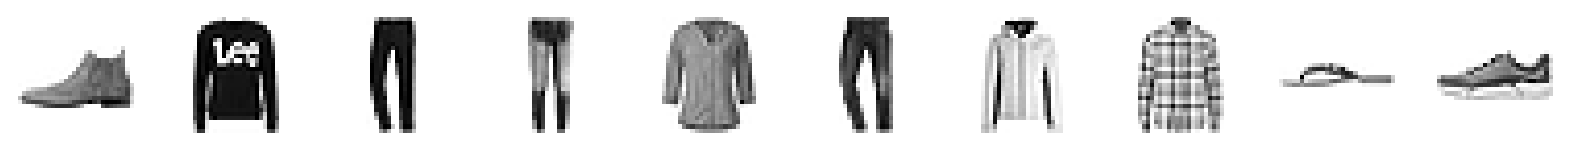

reconstructed


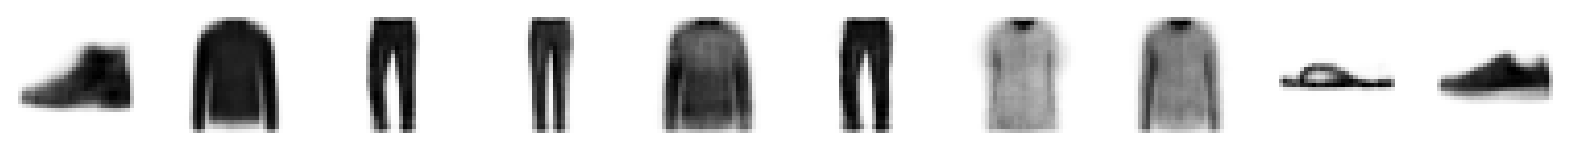

In [88]:
z_mean, z_log_var, recontruction = vae.predict(example_images)
print("real images")
display(example_images)
print("reconstructed")
display(recontruction)

In [89]:
z_mean, z_var, z = encoder.predict(example_images)

219/219 [==============================] - 1s 6ms/step


In [90]:
print(z[:10])

[[-1.4008547   0.13764437]
 [ 0.11797491 -0.74839216]
 [ 2.358327   -1.3330269 ]
 [ 1.9433061   0.23836122]
 [-0.00767193  0.03868237]
 [ 1.7781216  -2.1762755 ]
 [ 0.41914317  1.4725788 ]
 [ 0.24853492  0.47192642]
 [-0.94509506  3.3313527 ]
 [-1.2127184   1.5583087 ]]


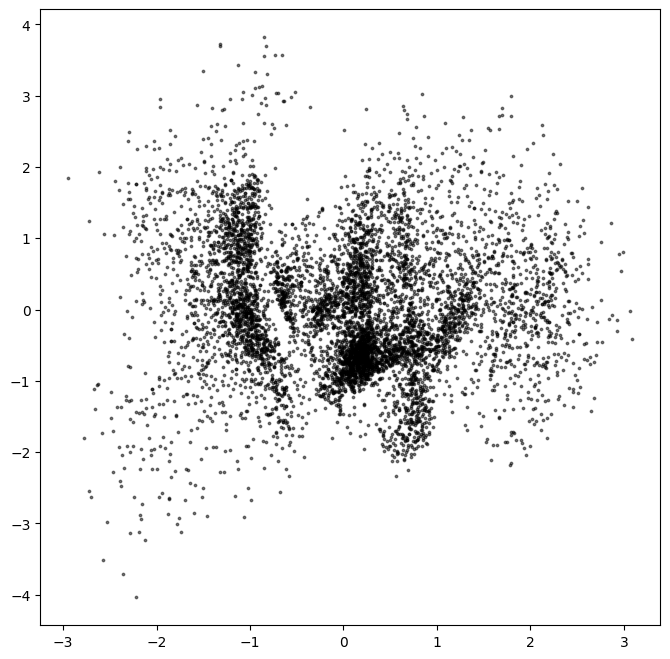

In [91]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

In [92]:
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [93]:
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 227ms/step


In [94]:
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

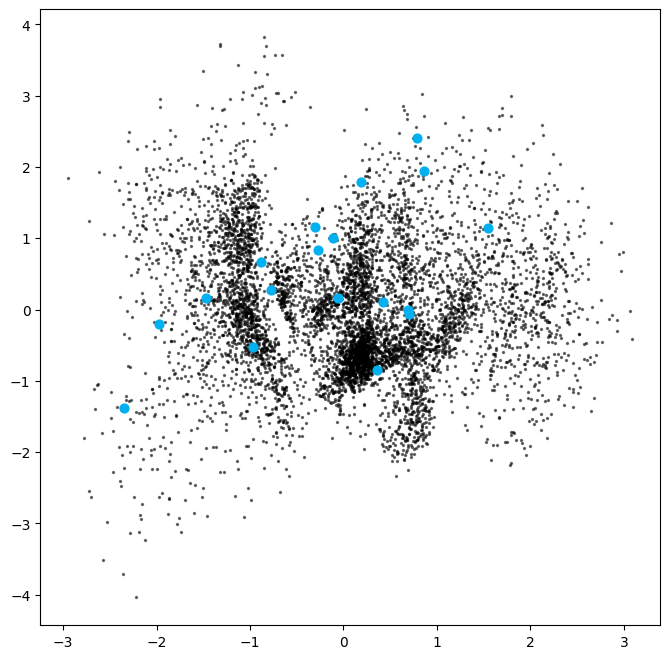

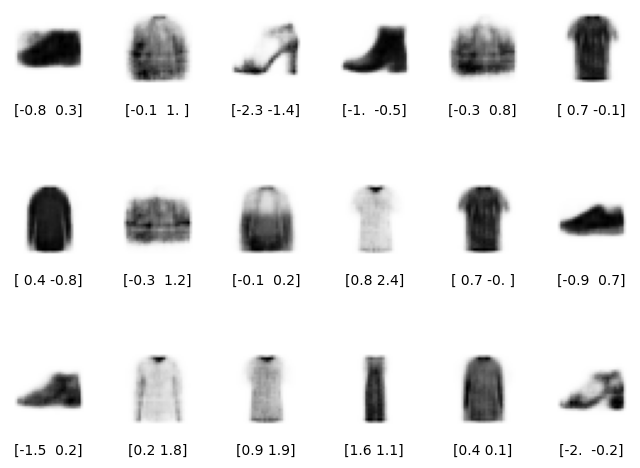

In [95]:
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

8/8 [==============================] - 0s 18ms/step


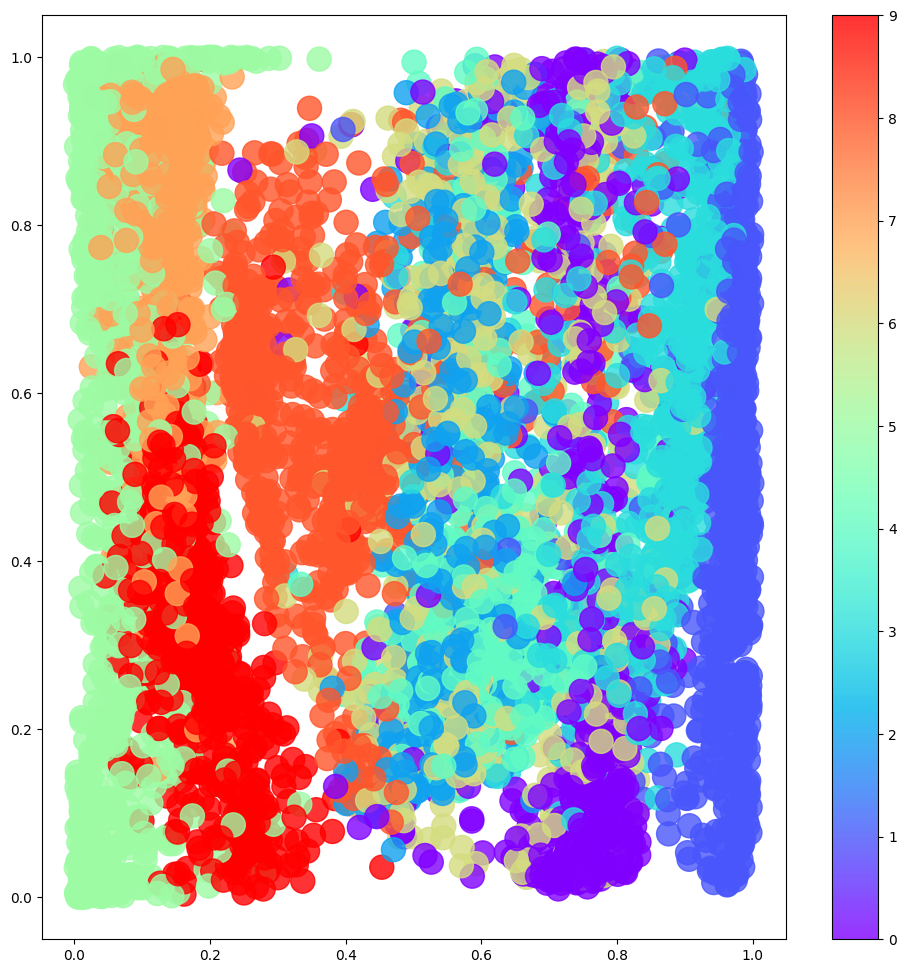

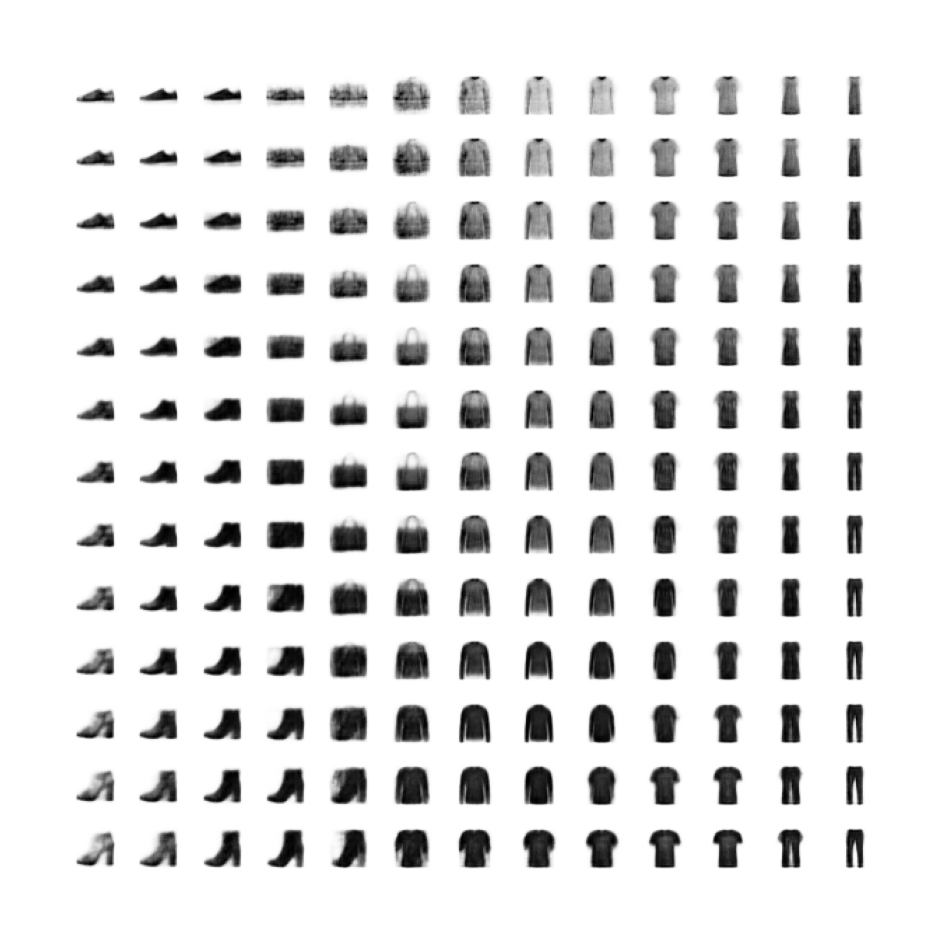

In [96]:
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")